## Importing Libraries

In [1]:
import gym
import random
from keras import Sequential
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.activations import relu, linear

## Setup Environment

In [2]:
import numpy as np
env = gym.make('MountainCar-v0')
env.seed(110)
np.random.seed(10)

## Creating DQN Agent

In [9]:
class DQN:

    """ Implementation of deep q learning algorithm """

    def __init__(self, action_space, state_space):

        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1.0
        self.gamma = .95
        self.batch_size = 64
        self.epsilon_min = .01
        self.lr = 0.001
        self.epsilon_decay = .995
        self.memory = deque(maxlen=100000)
        self.model = self.build_model()

    def build_model(self):

        model = Sequential()
        model.add(Dense(20, input_dim=self.state_space, activation=relu))
        model.add(Dense(24, activation=relu))
        model.add(Dense(self.action_space, activation=linear))
        model.compile(loss='mse', optimizer=Adam(lr=self.lr))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self):

        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)

        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

## Reward Mechanism

In [10]:
def get_reward(state):

    if state[0] >= 0.5:
        print("Car has reached the goal")
        return 10
    if state[0] > -0.4:
        return (1+state[0])**2
    return 0

## Model Training Function

In [11]:
def train_dqn(episode):

    loss = []
    agent = DQN(env.action_space.n, env.observation_space.shape[0])
    for e in range(episode):
        state = env.reset()
        state = np.reshape(state, (1, 2))
        score = 0
        max_steps = 3000
        for i in range(max_steps):
            action = agent.act(state)
            env.render()
            next_state, reward, done, _ = env.step(action)
            reward = get_reward(next_state)
            score += reward
            next_state = np.reshape(next_state, (1, 2))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            if done:
                print("episode: {}/{}, score: {}".format(e, episode, score))
                break
        loss.append(score)
    return loss

In [12]:
def random_policy(episode, step):

    for i_episode in range(episode):
        env.reset()
        for t in range(step):
            env.render()
            action = env.action_space.sample()
            state, reward, done, info = env.step(action)
            if done:
                print("Episode finished after {} timesteps".format(t+1))
                break
            print("Starting next episode")

## Simulation and Training

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Discrete(3)
episode: 0/100, score: 5.3404510067951305
episode: 1/100, score: 5.619194088490328
episode: 2/100, score: 2.9253129914387412
episode: 3/100, score: 58.24247354202909
episode: 4/100, score: 50.58122100167996
episode: 5/100, score: 54.26087280734667
episode: 6/100, score: 57.25188337901482
episode: 7/100, score: 54.04642063423588
episode: 8/100, score: 51.02873939868207
episode: 9/100, score: 52.2806925668602
episode: 10/100, score: 57.211379822799316
episode: 11/100, score: 61.35731506167554
episode: 12/100, score: 53.82446693938679
episode: 13/100, score: 72.22537609985885
episode: 14/100, score: 58.84401302752526
episode: 15/100, score: 51.59536900456225
episode: 16/100, score: 62.66368558535375
episode: 17/100, score: 59.395693563076144
episode: 18/100, score: 52.18616535726073
episode: 19/100, score: 59.39708798402614
episode: 20/100, score: 49.76336852998057
episode: 21/100, score: 61.44628541818607
episode: 22/100, score: 

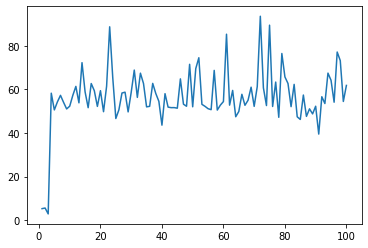

In [13]:
print(env.observation_space)
print(env.action_space)
episodes = 100
loss = train_dqn(episodes)
plt.plot([i+1 for i in range(episodes)], loss)
plt.show()